In [1]:
import math

import re

import time

from google.colab import drive

In [2]:

try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [3]:
import pandas as pd

import numpy as np

import h5py

from gensim.models import Word2Vec

import gensim.models

from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Embedding

from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation

from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import SimpleRNN

from tensorflow.keras.layers import GRU

from tensorflow.keras.preprocessing.sequence import pad_sequences 

import re

from nltk.tokenize import word_tokenize

import nltk

from nltk.corpus import stopwords 

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_clickbait = pd . read_csv ('/content/drive/My Drive/clickbait_data' , sep = ' \ n ' , header = None )

data_noclickbait = pd . read_csv ('/content/drive/My Drive/non_clickbait_data' , sep = ' \ n ' , header = None )

data_clickbait = data_clickbait.sample(frac = 7.5/16)

data_noclickbait = data_noclickbait.sample(frac = 7.5/16)

data_clickbait['class'] = [1 for i in range(7500)]

data_noclickbait['class'] = [0 for i in range(7500)] 

data_Final = pd . concat (( data_clickbait , data_noclickbait ), ignore_index = True ) 

df = data_Final . rename ( columns = { 0 : "text" })

df = df . sample ( frac = 1 ). reset_index ( drop = True )

print (df.shape)

print (df.head(5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


(15000, 2)
                                                text  class
0                  21 Times Idris Elba Gave You Life      1
1  9 Jokes That'll Make Biswa Kalyan Rath Your Ne...      1
2              Microsoft reports 60% profit increase      0
3  These Are The 2016 Books Readers Are Most Pump...      1
4  This Video Perfectly Captures The Sriracha Lov...      1


In [6]:
df

,text,class
0,21 Times Idris Elba Gave You Life,1
1,9 Jokes That'll Make Biswa Kalyan Rath Your Ne...,1
2,Microsoft reports 60% profit increase,0
3,These Are The 2016 Books Readers Are Most Pump...,1
4,This Video Perfectly Captures The Sriracha Lov...,1
...,...,...
14995,Women Turned Into Mermaids And Fulfilled All T...,1
14996,Rebel Wilson Wants One Direction Fans To Know ...,1
14997,Results of the 2005 New Zealand General Election,0
14998,Australian Prime Minister blames asylum seeker...,0


In [7]:
stop_words  =  set ( stopwords . words ( 'english' ))

In [8]:
from sklearn.model_selection import train_test_split

L = []
for  i , token  in  enumerate ( df [ 'text' ]):
    words = [ w  for  w  in  token . split () if  not  w  in  stop_words ]
    L . append ( len ( words ))
    
sequence_size = max ( L )


X = df['text']

y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [9]:
y_train = np.array(y_train)

y_test = np.array(y_test)

y_val = np.array(y_val)

In [10]:
from keras.preprocessing.text import Tokenizer 

tokenizer = Tokenizer(num_words = 15000)

tokenizer.fit_on_texts(X_train)

sequences_1 = tokenizer.texts_to_sequences(X_train)

train_data = pad_sequences(sequences_1, maxlen = sequence_size , padding = 'post')

tokenizer.fit_on_texts(X_test)

sequences_2 = tokenizer.texts_to_sequences(X_test)

test_data = pad_sequences(sequences_2, maxlen = sequence_size , padding = 'post')

sequences_3 = tokenizer.texts_to_sequences(X_val)

val_data = pad_sequences(sequences_3, maxlen = sequence_size , padding = 'post')

Using TensorFlow backend.


In [11]:
class PositionalEncoding(layers.Layer):
  
    def __init__(self) :

        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model) :

        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))

        return pos * angles

    def call(self, inputs) :

        seq_length = inputs.shape.as_list()[-2]

        d_model = inputs.shape.as_list()[-1]

        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)

        angles[:, 0::2] = np.sin(angles[:, 0::2])

        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        pos_encoding = angles[np.newaxis, ...]

        return inputs + tf.cast(pos_encoding, tf.float32)

In [12]:
def scaled_dot_product_attention(queries, keys, values, mask) :
  
    product = tf.matmul(queries, keys, transpose_b  = True)
    
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)

    scaled_product = product / tf.math.sqrt(keys_dim)
    
    if mask is not None :

        scaled_product += (mask * -1e9)

    attention = tf.matmul(tf.nn.softmax(scaled_product, axis = -1), values)
    
    return attention

In [13]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, nb_proj) :

        super(MultiHeadAttention, self).__init__()

        self.nb_proj = nb_proj
        
    def build(self, input_shape) :

        self.d_model = input_shape[-1]

        assert self.d_model % self.nb_proj == 0
        
        self.d_proj = self.d_model // self.nb_proj
        
        self.query_lin = layers.Dense(units=self.d_model)

        self.key_lin = layers.Dense(units=self.d_model)

        self.value_lin = layers.Dense(units=self.d_model)
        
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)

        shape = (batch_size,-1, self.nb_proj,self.d_proj)

        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)

        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask) :

        batch_size = tf.shape(queries)[0]
        
        queries = self.query_lin(queries)

        keys = self.key_lin(keys)

        values = self.value_lin(values)
        
        queries = self.split_proj(queries, batch_size)

        keys = self.split_proj(keys, batch_size)

        values = self.split_proj(values, batch_size)
        
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention,shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs

In [14]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate) :

        super(EncoderLayer, self).__init__()

        self.FFN_units = FFN_units

        self.nb_proj = nb_proj

        self.dropout_rate = dropout_rate
    
    def build(self, input_shape) :

        self.d_model = input_shape[-1]
        
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)

        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)

        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")

        self.dense_2 = layers.Dense(units=self.d_model)

        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)

        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training) :

        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        
        attention = self.dropout_1(attention, training=training)

        attention = self.norm_1(attention + inputs)
        
        outputs = self.dense_1(attention)

        outputs = self.dense_2(outputs)

        outputs = self.dropout_2(outputs, training=training)
        
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [15]:
import os

dir = '/content/drive/My Drive/Glove'

embed_index = dict()
f = open(os.path.join(dir, 'glove.6B.300d.txt'), encoding="utf8")

In [16]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embed_index[word] = coefs
f.close()

In [17]:
len(tokenizer.word_index)

15047

In [18]:
X_train[10]

'17 "Home Alone" Tweets That Will Make You Laugh Out Loud'

In [19]:
train_data[10]

array([4300, 1084, 2702, 3298,  552,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [20]:
sequences_1[10]

[4300, 1084, 2702, 3298, 552]

In [21]:
embed_matrix = np.zeros((15000, 300))

for word, i in tokenizer.word_index.items():
    if i < 15000 :
        embed_vector = embed_index.get(word)
        if embed_vector is not None:
            embed_matrix[i] = embed_vector

In [22]:
embed_matrix.shape

(15000, 300)

In [23]:
class Encoder(layers.Layer) :
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder") :

        super(Encoder, self).__init__(name=name)

        self.nb_layers = nb_layers

        self.d_model = d_model
        
        self.embedding = layers.Embedding(vocab_size, d_model , weights = [embed_matrix])

        self.pos_encoding = PositionalEncoding()

        self.dropout = layers.Dropout(rate=dropout_rate)

        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training) :

        outputs = self.embedding(inputs)

        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        outputs = self.pos_encoding(outputs)

        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers) :
          
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

In [24]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, training = True):
        enc_mask = self.create_padding_mask(enc_inputs)
        
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        
        return enc_outputs

In [25]:
D_MODEL = 300

NB_LAYERS = 3

FFN_UNITS = 512 

NB_PROJ = 6

DROPOUT_RATE = 0.1

transformer = Transformer(vocab_size_enc = 15000,
                          d_model = D_MODEL,
                          nb_layers = NB_LAYERS,
                          FFN_units = FFN_UNITS,
                          nb_proj = NB_PROJ,
                          dropout_rate = DROPOUT_RATE)


inputs = layers.Input(shape = (sequence_size,))

x = transformer(inputs)

x = layers.Flatten()(x)

x = layers.Dense(512, activation="relu")(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(256, activation="relu")(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(128, activation="relu")(x)

x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
transformer (Transformer)    (None, 21, 300)           6511236   
_________________________________________________________________
flatten (Flatten)            (None, 6300)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3226112   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0     

In [26]:
history = model.fit(train_data , y_train  , batch_size = 64 , epochs = 20 , validation_data = (val_data , y_val), verbose = 1)

Epoch 1/20
141/141 [==============================] - 11s 75ms/step - loss: 0.7194 - accuracy: 0.6260 - val_loss: 0.4564 - val_accuracy: 0.8140
Epoch 2/20
141/141 [==============================] - 10s 69ms/step - loss: 0.2547 - accuracy: 0.9020 - val_loss: 0.8936 - val_accuracy: 0.6933
Epoch 3/20
141/141 [==============================] - 10s 68ms/step - loss: 0.1551 - accuracy: 0.9486 - val_loss: 0.7320 - val_accuracy: 0.7463
Epoch 4/20
141/141 [==============================] - 10s 68ms/step - loss: 0.1233 - accuracy: 0.9597 - val_loss: 1.0112 - val_accuracy: 0.7147
Epoch 5/20
141/141 [==============================] - 10s 67ms/step - loss: 0.0680 - accuracy: 0.9786 - val_loss: 1.2665 - val_accuracy: 0.7040
Epoch 6/20
141/141 [==============================] - 10s 68ms/step - loss: 0.0611 - accuracy: 0.9806 - val_loss: 1.1453 - val_accuracy: 0.7227
Epoch 7/20
141/141 [==============================] - 10s 69ms/step - loss: 0.0748 - accuracy: 0.9773 - val_loss: 1.1114 - val_accuracy:

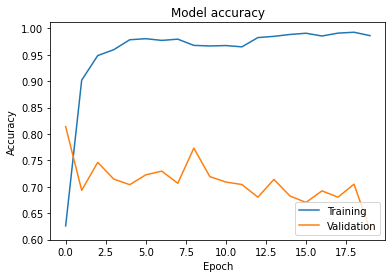

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

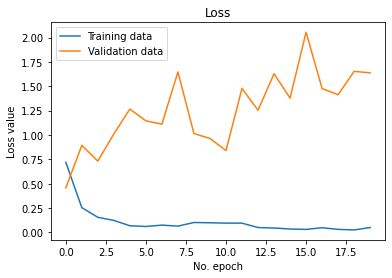

In [28]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [29]:
y_pred = model.predict(test_data)

In [30]:
y_pred

array([[0.95321625],
       [0.00593426],
       [0.00585335],
       ...,
       [0.00597547],
       [0.89004874],
       [0.00600061]], dtype=float32)

In [31]:
y_pred.shape

(3000, 1)

In [32]:
for i in range(y_pred.shape[0]) :

  if y_pred[i][0] >= 0.5 :

    y_pred[i][0] = 1

  else :

    y_pred[i][0] = 0

In [33]:
y_pred = y_pred.astype('int64')

In [34]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [35]:
y_test = y_test.reshape(-1,1)

In [36]:
metrics  =  classification_report (y_test , y_pred)

print ('Classification Report ')

print("\n")

print (metrics)

cm  =  confusion_matrix (y_test,y_pred)

print ('Confusion Matrix')

print("\n")

print (cm)

Classification Report 


              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1492
           1       0.61      0.59      0.60      1508

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.61      0.61      3000

Confusion Matrix


[[932 560]
 [615 893]]
